In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import glob

In [2]:
def read_imaris_csv(csv_path):
    """
    Read Imaris segmentation from .csv file (generated by Imaris).

    The returned DataFrame contains single cells as rows and their specifics as columns. The latter are:
    * x, y, z: float, cartesian coordinates of the cell (in micrometers and in the Imaris coordinate system - this might
        not be the array coordinate system).
    * frame: integer, number of the frame contatining the cell.
    :param csv_path: string, path to the .csv file
    :return: pd.DataFrame, containing individual cells per row and corresponding information as mentioned above.
    """
    df = pd.read_csv(csv_path, skiprows=3)
    df = df.drop(columns=['Unit', 'Category', 'Collection','ID', 'Unnamed: 8'], index=1, errors='ignore')
    df = df.rename(columns={'Cell Position X': 'x',
                            'Cell Position Y': 'y',
                            'Cell Position Z': 'z',
                            'Position X': 'x',
                            'Position Y': 'y',
                            'Position Z': 'z',
                            'Time': 'frame'})
    return df

def neighbour_density_estimation(p_source, p_target=None, n_neighbours=6):
    """
    Compute the density of a point cloud based on the distance of a point from its n neighbours.

    The k-d tree is constructed using the points p_source and it is queried on the points
    p_target. For each target point the average distance to its n nearest neighbours (source points)
    is returned.
    :param p_source: np.array, contains the x, y, z coordinated of the points used
        to estimate condtruct the k-d tree.
        shape: [n, 3], e.g. [[x0, y0, z0], [x1, y1, z1], ... ]
    :param p_target: np.array, contains the x, y, z coordinates of the points used
        to evaluate the estimated density fields.
        Same structure as p_source.
        If none, the density of the source points is calculated.
    :param n_neighbours: int, number of nearest neighbours over which the distance is averaged.
    :return: np.array, contains the estimated source density at the target points.
    """
    if p_target is None:
        p_target = p_source
    tree = KDTree(p_source)
    dist, ind = tree.query(p_target, k=n_neighbours + 1)
    return 1. / dist[:, 1:].mean(axis=1)

## Read in files

In [99]:
path = 'data/mg_distribution/*'
files = glob.glob(path+'*.csv')

In [101]:
_list = []
for f in files:
    _sdf = read_imaris_csv(f)
    splt = f.split('/')[-1].split('_')
    ctype = splt[2]
    sample = splt[0]
    _sdf['cell type'] = ctype
    _sdf['sample'] = sample
    _list.append(_sdf)
df = pd.concat(_list)

In [103]:
df['sid'] = df['Original Image Name']

## Calculate of densities 
We calculate cell densities (1/spacing) for both cell types (microglia and dead neurons) seperately per analysed image.

In [117]:
_list = []
for sid in df['sid'].unique():
    for ct in df['cell type'].unique():
        _sdf = df.loc[(df['sid']==sid) &
                      (df['cell type']==ct)].copy()
        d = neighbour_density_estimation(_sdf[list('xyz')].values, n_neighbours=1)
        df.loc[(df['sid']==sid) &
               (df['cell type']==ct), 'density'] = d


## Fig. 1B: Count of MG and dead neurons / optic tectum

In [118]:
df_count = df.groupby(['sid', 'cell type']).count().reset_index()[['sid', 'cell type', 'x']].rename({'x':'count'}, axis=1)

In [119]:
df_count['cell type'].replace({'Dead-neurons':'Dead\nneurons'}, inplace=True)

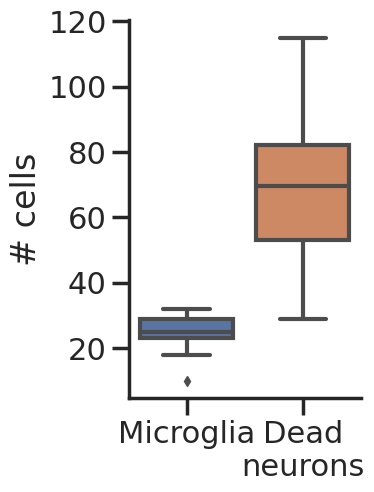

In [120]:
sns.set(style='ticks', rc={'figure.dpi':100, 'figure.figsize':(3,5)},
        context='poster')
ax = plt.subplot(111)
sns.boxplot(
    data=df_count,
    x='cell type',
    y='count',
    order=['Microglia', 'Dead\nneurons'],
    ax=ax,
)
plt.ylabel('# cells')

plt.xlabel('')
sns.despine()
plt.savefig('plots/fig1B.png')

## Fig. 1C: microglia spacing

In [121]:
df['spacing'] = 1/df['density']

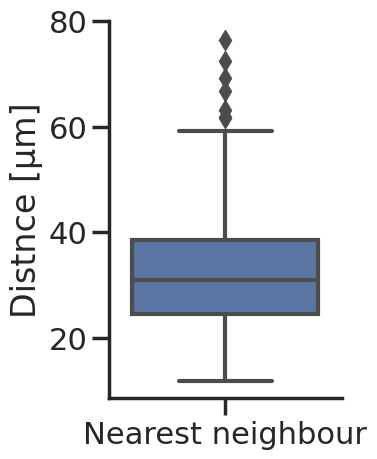

In [122]:
sns.set(style='ticks', rc={'figure.dpi':100, 'figure.figsize':(3,5)},
        context='poster')
ax = plt.subplot(111)
sns.boxplot(
    data=df.loc[df['cell type'] == 'Microglia'],
    x='cell type',
    y='spacing',
    fliersize=10,
    ax=ax,
)

plt.yticks([20,40,60,80])
plt.ylabel('Distnce [μm]')
plt.xticks([0], ['Nearest neighbour'])
plt.xlabel('')
sns.despine()
plt.savefig('plots/fig1C.png')